Given the constrains on the RFSoC driver you can only use a rabi sequence with a frequency equal to 31.25, 50, 62.5 or 125MHz (the frequency period should be a multiple of 4ns)

# Import library and stations

In [1]:
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes.dataset.plotting import plot_dataset,plot_by_id
from qcodes.logger.logger import start_all_logging
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm 
from qcodes.loops import Loop
from matplotlib import cm
from cycler import cycler
from pprint import pprint
from time import sleep

import matplotlib.pyplot as plt
import plotly.express as px
import pickle as pk
import qcodes as qc
import pandas as pd
import numpy as np
import datetime
import warnings
import time
import json
import sys
import os

%matplotlib widget

In [2]:
# path to the RFSoC driver 
sys.path.append(r'C:\Users\nicolas.roch\measurement\Experiment\Drivers')

from RFSoC import RFSoC
try:
    rfsoc = RFSoC('RFSoC', 'TCPIP::{}::{}::SOCKET'.format('192.168.0.11',5001))
except KeyError as er:
    rfsoc.close_all()
    rfsoc = RFSoC('RFSoC', 'TCPIP::{}::{}::SOCKET'.format('192.168.0.11',5001))

    
# to be launched once after a rfsoc reboot  
# rfsoc.reset_PLL()

# whether you want to print or not information for rfsoc debugging
rfsoc.debug_mode = False
# visual representation of the sequence played / Not suitable for very long sequence 
# (i.e. more than few hundred of pulses) 
rfsoc.display_sequence = True  
rfsoc.debug_mode_plot_waveforms = False

## Convert Volt in dBm an vice-versa

In [3]:
def powtov(power) :
    poww = 10**(power/10)/1000
    v = np.sqrt(50*poww*2)
    return v
def vtopow(v) :
    poww = v**2/(100)
    power = 10*np.log10(poww)+30
    return power

## Function that can be use to compute a working frequency

This function can be used to compute a frequency compatible with a rabi sequence. However some of this frequency are rational and not decimal. Hence time errors will accumulate. I strongly suggest to only use the frequencies reported above. 

In [4]:
def compatible_freq_rabi(freq_sig):

    p_sig = 1/(freq_sig*1e-3) #in ns
    r = (p_sig % (1/rfsoc.FPGA_clock*1e9))
    if r != 0:
        r = (p_sig % (1/rfsoc.FPGA_clock*1e9)) 
        p_sig = p_sig  -  r
        freq_sig = 1e3/p_sig
    return freq_sig  

# Rfsoc initialisation

## Pulses parameters

### Channels 

In [5]:
channel_ex = 2
channel_ro = 1
channel_trigger = 3
ch_demod = [1]

###  Pulses parameters

In [6]:
amp_sig = 0.9 # Volt peak to peak
freq_sig = compatible_freq_rabi(62.5) # MHz
phase_sig = 0 # degree
dc_off = 0 # Volt 

param_sin = {'amp':amp_sig,
             'freq':freq_sig,
             'dc_offset':dc_off,
             'phase_offset':phase_sig*np.pi/180}

param_demod = {'amp':1,
             'freq':freq_sig,
             'dc_offset':0,
             'phase_offset':0}

if freq_sig not in [31.25, 50, 62.5, 125] :
    print('This frequency can cause error')

### Time vectors in µs

In [42]:
time_start = rfsoc.time_conversion(1) 
acq_length = rfsoc.time_conversion(5) 
time_shift = rfsoc.time_conversion(0)
time_wait_start = rfsoc.time_conversion(0.511)
time_wait_stop = rfsoc.time_conversion(2)
time_wait_step = rfsoc.time_conversion(0.391)



# --- this step ensure that the time step is a multiple of the signal period
time_wait_step = int(1e3*time_wait_step)  - int(1e3*time_wait_step) % (1/(freq_sig*1e-3))
time_wait_step = time_wait_step*1e-3


time_vec = np.arange(time_wait_start, time_wait_stop + time_wait_step, time_wait_step)

# --- revert the time vector to start with the longest pulses 
time_vec = time_vec[::-1]


# --- time vector for the different pulses 
time_loop = time_start + time_vec + acq_length + time_shift 
time_loop = np.array([np.sum(time_loop[:k]) for k in range(len(time_loop))])

time_start_ex = time_start + time_loop
time_start_ro = time_start_ex + time_vec 
time_start_adc = time_start_ro + time_shift 


# --- define the pointer time vector 
time_diff = max(time_vec) - time_vec

## Pulses sequence creation

In [43]:
pulses = pd.DataFrame()

for k in range(len(time_vec)): 
    if k == 0:
        EX_pulse = dict(label='Ex_pulse_%i'%k, 
                          module='DAC', 
                          channel=channel_ex, 
                          mode='sin', 
                          start=time_start_ex[k], 
                          length=time_vec[k],
                          repetitions=1,
                          param=param_sin, 
                          LUT=True, 
                          starting_pointer=time_diff[k],
                          parent=None)
        
        RO_pulse = dict(label='RO_pulse_%i'%k, 
                  module='DAC', 
                  channel=channel_ro, 
                  mode='sin', 
                  start=time_start_ro[k], 
                  length=acq_length,
                  repetitions=1,
                  starting_pointer=0, 
                  param=param_sin,
                  LUT=True, 
                  parent=None)
        
        RO_acq = dict(label='RO_acq_%i'%k, 
                  module='ADC', 
                  channel=channel_ro, 
                  mode='sin', 
                  LUT = True, 
                  demodulation_channels=ch_demod,
                  start=time_start_adc[k], 
                  length=acq_length, 
                  repetitions=1,
                  param=[param_demod], 
                  parent=None)
        
            
        
    else: 
        EX_pulse = dict(label='Ex_pulse_%i'%k, 
                  module='DAC', 
                  channel=channel_ex, 
                  mode='sin', 
                  start=time_start_ex[k], 
                  length=time_vec[k],
                  repetitions=1,
                  param=param_sin, 
                  starting_pointer=time_diff[k],
                  parent=None)
        

        RO_pulse = dict(label='RO_pulse_%i'%k, 
                          module='DAC', 
                          channel=channel_ro, 
                          mode='sin', 
                          start=time_start_ro[k], 
                          length=acq_length,
                          repetitions=1,
                          starting_pointer=0, 
                          param=param_sin,
                          parent=None)

    
        RO_acq = dict(label='RO_acq_%i'%k, 
                  module='ADC', 
                  channel=channel_ro, 
                  mode='sin', 
                  demodulation_channels=ch_demod,
                  start=time_start_adc[k], 
                  length=acq_length, 
                  repetitions=1,
                  param=[param_demod], 
                  parent=None)
    
    
    pulses = pd.concat([pulses, pd.DataFrame.from_records([EX_pulse])], ignore_index=True)
    pulses = pd.concat([pulses, pd.DataFrame.from_records([RO_pulse])], ignore_index=True)
    pulses = pd.concat([pulses, pd.DataFrame.from_records([RO_acq])], ignore_index=True)
    
    
trigger_pulse = dict(label='trigger', 
                     module='DAC', 
                     channel=channel_trigger, 
                     mode='trigger', 
                     start =0, 
                     length=400e-3, 
                     repetitions=1,
                     LUT=True,
                     starting_pointer=0,
                     param=None, 
                     parent=None)


                     
pulses = pd.concat([pulses, pd.DataFrame.from_records([trigger_pulse])], ignore_index=True)
    
rfsoc.pulses = pulses


## Rfsoc setting, memory filling and sequencing

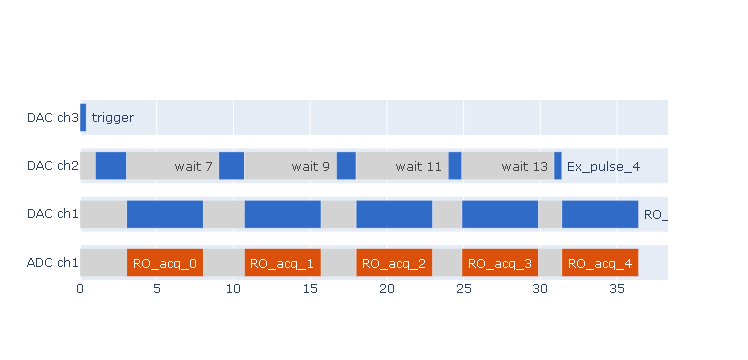

In [44]:
n_points = 500 # number of time the displayed sequence is played  (loop out in the documentation)

rfsoc.acquisition_mode('INT') # can be 'RAW' or 'INT'
# rfsoc.acquisition_mode('RAW') # can be 'RAW' or 'INT'
rfsoc.n_points(n_points)
rfsoc.process_sequencing_IQ_table()

# Measurement

In [36]:
res=rfsoc.IQINT_ALL()

IntProgress(value=0, max=26000)

In [37]:
I_no_avg = res[1][channel_ro - 1].reshape(len(time_vec), rfsoc.n_points()) # I vector per iteration of the sequence
Q_no_avg = res[0][channel_ro - 1].reshape(len(time_vec), rfsoc.n_points()) # same for Q 

amp_no_avg = np.sqrt(I_no_avg**2 + Q_no_avg**2) # amplitude vec 
ph_no_avg = np.arctan(I_no_avg/Q_no_avg)        # phase vector 
ph_no_avg_unwrap = np.unwrap(2*ph_no_avg, axis=0)/2 # unwraped phase 

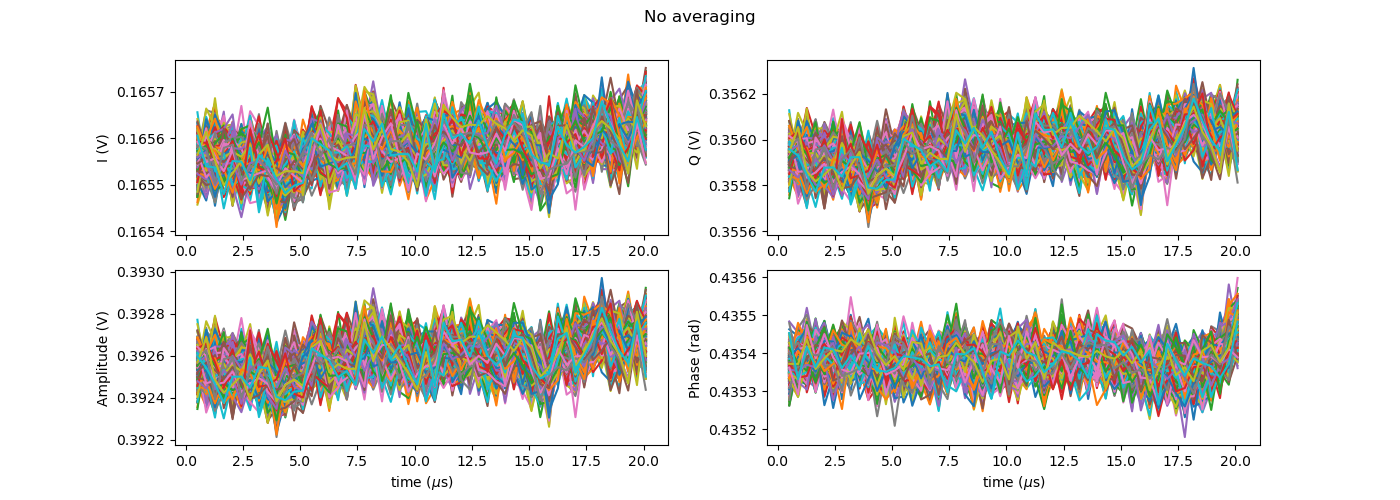

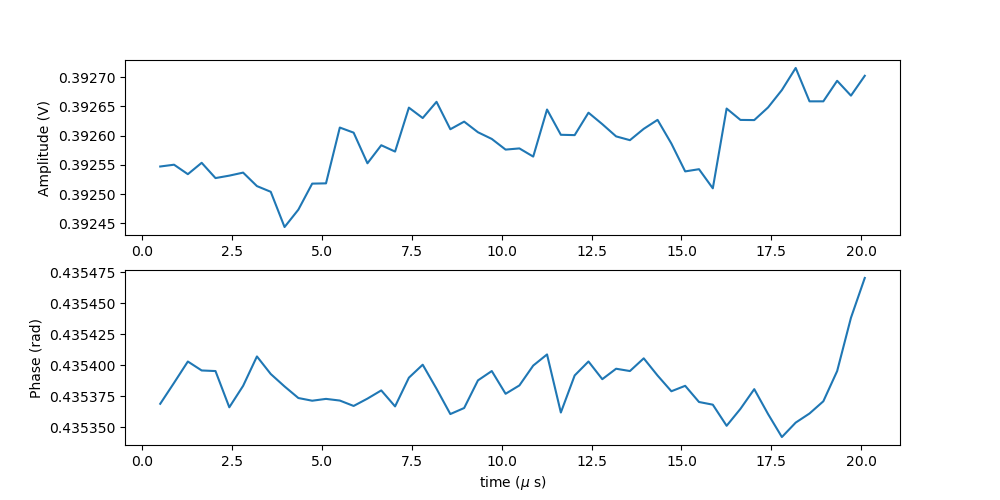

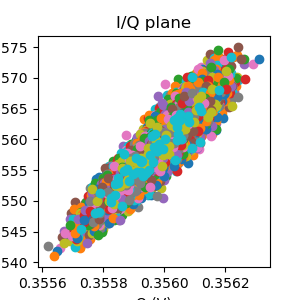

In [38]:
fig, ax = plt.subplots(2, 2, figsize = (14, 5))
fig2, ax2 = plt.subplots(2, 1, figsize=(10,5))
fig3, ax3 = plt.subplots(1, 1, figsize = (3, 3))

fig.suptitle('No averaging')
ax[0, 0].set_ylabel('I (V)')
ax[0, 1].set_ylabel('Q (V)')
ax[1, 0].set_ylabel('Amplitude (V)')
ax[1, 1].set_ylabel('Phase (rad)')

ax[1, 0].set_xlabel(r'time ($\mu$s)')
ax[1, 1].set_xlabel(r'time ($\mu$s)')

ax2[1].set_xlabel(r'time ($\mu$ s)')
ax2[0].set_ylabel('Amplitude (V)')
ax2[1].set_ylabel('Phase (rad)')


ax3.set_title('I/Q plane')
ax3.set_ylabel('I (V)')
ax3.set_xlabel('Q (V)')

for k in range(int(n_points)): 
    ax[0, 0].plot(time_vec, I_no_avg[:,k])
    ax[0, 1].plot(time_vec, Q_no_avg[:,k])
    ax[1, 0].plot(time_vec, amp_no_avg[:,k])
    ax[1, 1].plot(time_vec, ph_no_avg_unwrap[:,k])
    
    
ax2[0].plot(time_vec, np.average(amp_no_avg, axis=1))
ax2[1].plot(time_vec, np.average(ph_no_avg_unwrap, axis=1))
    


for k in range(n_points): 
    ax3.scatter(Q_no_avg[:,k], I_no_avg[:,k])

In [ ]:
# res=rfsoc.RAW_ALL()

In [ ]:
# fig, ax = plt.subplots(1, 1)

# for chd in ch_demod: 
#     print(chd)
#     data = res[chd - 1]


#     for k in range(len(data[:,0])):
#     # for k in range(1):
#         signal = data[k,:]
#         time_vec = np.arange(len(signal))/(2e9)



#         ax.plot(time_vec*1e6, signal)
#         print(np.average(signal))